Correlation between GitBug-Java and Defects4J costs: 0.9423
P-value: 0.0005


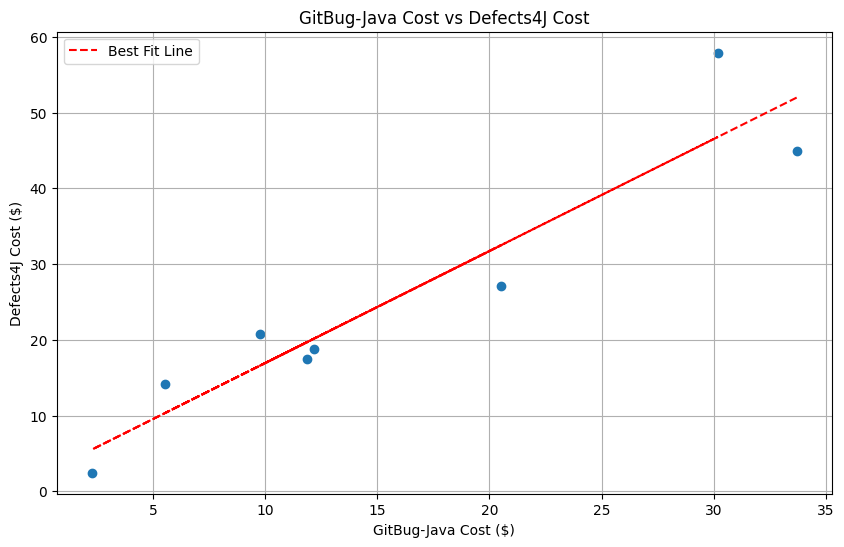

Best fit line equation: y = 1.48x + 2.15
For a GitBug-Java cost of $100.00, the predicted Defects4J cost is $150.03


In [1]:
import json
import os
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def load_data(results_dir):
    data = []
    model_list = [
        ('gemini-1.5-pro-001', "google", "Google"),
        ('gemini-1.5-pro-002', "google", "Google"),
        ('gpt-4o-2024-08-06', "openai-chatcompletion", "OpenAI"),
        # ('o1-preview-2024-09-12', "openai-chatcompletion", "OpenAI"),
        ('llama-3.1-405b-instruct', 'openrouter', 'Meta'),
        ('deepseek-v2.5', 'openrouter', 'DeepSeek'),
        ('mistral-large-2407', 'openrouter', 'Mistral'),
        ('qwen-2.5-72b-instruct', 'openrouter', 'Alibaba Cloud'),
        ('claude-3-5-sonnet-20240620', 'anthropic', 'Anthropic'),
    ]
    benchmarks = ['defects4j', 'gitbugjava']
    metrics = ['ast_match@1', 'plausible@1']

    for llm_name, strategy, provider in model_list:
        row = {'name': llm_name, 'provider': provider, 'total_cost': 0}

        try:
            with open(f"{results_dir}/{llm_name}/total.json") as f:
                total_result = json.load(f)
                row['total_ast_match@1'] = total_result.get('ast_match@1', None)
                row['total_plausible@1'] = total_result.get('plausible@1', None)
                row['total_cost'] = total_result.get('cost', 0)
        except FileNotFoundError:
            print(f"Warning: total.json not found for {llm_name}")
            row['total_ast_match@1'] = None
            row['total_plausible@1'] = None

        for benchmark in benchmarks:
            try:
                with open(f"{results_dir}/{llm_name}/{benchmark}/statistics_{benchmark}_instruct_{strategy}.json") as f:
                    stats_result = json.load(f)
                    for metric in metrics:
                        row[f"{benchmark}_{metric}"] = stats_result.get(metric, None)

                with open(f"{results_dir}/{llm_name}/{benchmark}/costs_{benchmark}_instruct_{strategy}.json") as f:
                    cost_result = json.load(f)
                    row[f"{benchmark}_cost"] = cost_result.get('total_cost', 0)
                    row['total_cost'] += cost_result.get('total_cost', 0)
            except FileNotFoundError:
                print(f"Warning: Data not found for {llm_name} - {benchmark}")
                for metric in metrics:
                    row[f"{benchmark}_{metric}"] = None
                row[f"{benchmark}_cost"] = None

        data.append(row)

    return data

# Load the data
results_dir = os.path.join("..", 'results')
data = load_data(results_dir)

# Create a DataFrame
df = pd.DataFrame(data)

# Extract GitBug-Java and Defects4J costs
gitbug_costs = df['gitbugjava_cost'].dropna()
defects4j_costs = df['defects4j_cost'].dropna()

# Ensure we have matching data for both benchmarks
common_indices = gitbug_costs.index.intersection(defects4j_costs.index)
gitbug_costs = gitbug_costs[common_indices]
defects4j_costs = defects4j_costs[common_indices]

# Compute correlation
correlation, p_value = stats.pearsonr(gitbug_costs, defects4j_costs)

print(f"Correlation between GitBug-Java and Defects4J costs: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(gitbug_costs, defects4j_costs)
plt.xlabel('GitBug-Java Cost ($)')
plt.ylabel('Defects4J Cost ($)')
plt.title('GitBug-Java Cost vs Defects4J Cost')

# Add a best fit line
m, b = np.polyfit(gitbug_costs, defects4j_costs, 1)
plt.plot(gitbug_costs, m*gitbug_costs + b, color='red', linestyle='--', label='Best Fit Line')

plt.legend()
plt.grid(True)
plt.show()

# Print the equation of the best fit line
print(f"Best fit line equation: y = {m:.2f}x + {b:.2f}")

# Predict Defects4J cost based on GitBug-Java cost
gitbug_cost = 100  # Example cost for GitBug-Java
predicted_defects4j_cost = m * gitbug_cost + b
print(f"For a GitBug-Java cost of ${gitbug_cost:.2f}, the predicted Defects4J cost is ${predicted_defects4j_cost:.2f}")

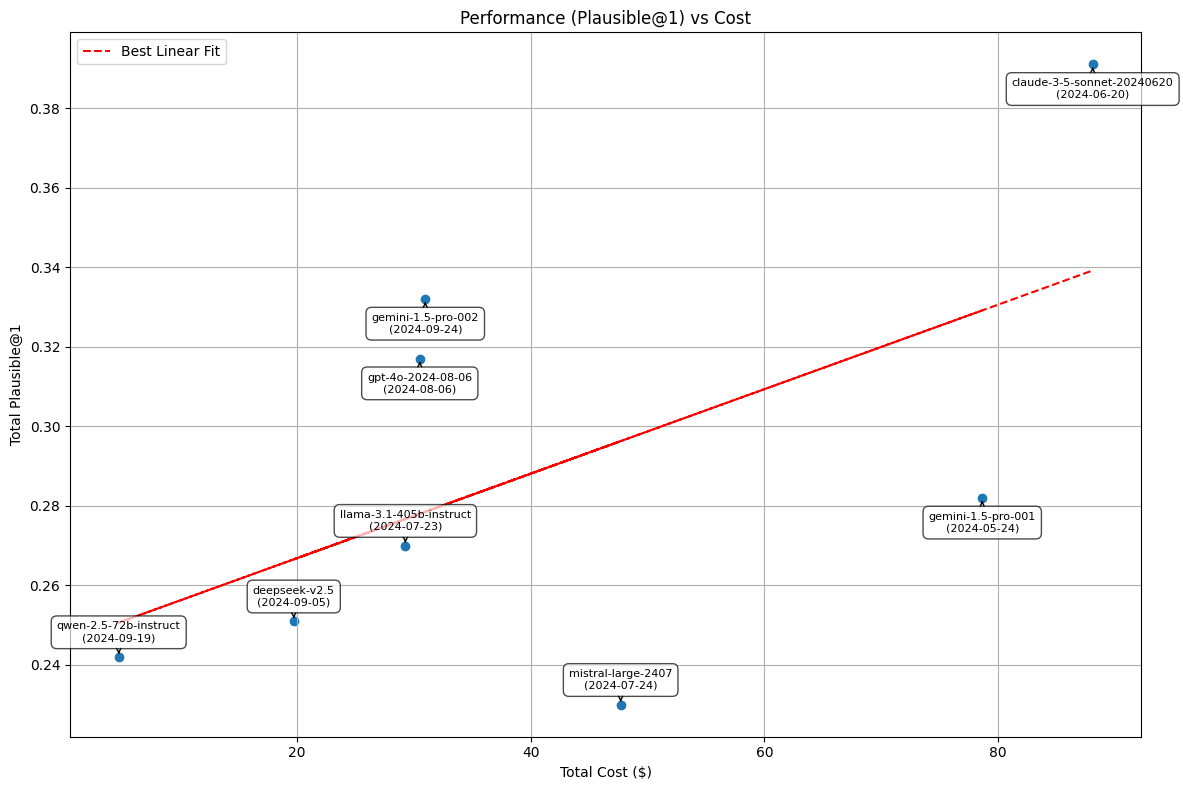

Best fit line equation: y = 0.001062x + 0.2456
Correlation between Total Cost and Total Plausible@1: 0.5636
P-value: 0.1457


In [4]:
# Create a scatter plot of performance per cost
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['total_cost'], df['total_plausible@1'])

# Define a dictionary with release dates for each model
with open('../results/release_dates.json') as f:
    release_dates = json.load(f)

# Add labels for each point with release dates
for i, row in df.iterrows():
    model_name = row['name']
    release_date = release_dates.get(model_name, 'N/A')
    
    label = f"{model_name}\n({release_date})"
    x, y = row['total_cost'], row['total_plausible@1']
    
    # Adjust the position of the label to stay within the plot
    ha = 'center'
    va = 'bottom' if y < df['total_plausible@1'].median() else 'top'
    xytext = (0, 10) if va == 'bottom' else (0, -10)
    
    plt.annotate(label, (x, y), 
                 xytext=xytext, textcoords='offset points', 
                 ha=ha, va=va, fontsize=8, 
                 bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.7),
                 arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

plt.xlabel('Total Cost ($)')
plt.ylabel('Total Plausible@1')
plt.title('Performance (Plausible@1) vs Cost')

# Add a best fit line
m, b = np.polyfit(df['total_cost'], df['total_plausible@1'], 1)
plt.plot(df['total_cost'], m*df['total_cost'] + b, color='red', linestyle='--', label='Best Linear Fit')

plt.legend()
plt.grid(True)

# Adjust the plot layout to make room for annotations
plt.tight_layout()

# Save as pdf
plt.savefig('performance-vs-cost.pdf', format='pdf', bbox_inches='tight')
plt.savefig('performance-vs-cost.png', format='png', bbox_inches='tight')

plt.show()

# Print the equation of the best fit line
print(f"Best fit line equation: y = {m:.6f}x + {b:.4f}")

# Calculate and print correlation
correlation, p_value = stats.pearsonr(df['total_cost'], df['total_plausible@1'])
print(f"Correlation between Total Cost and Total Plausible@1: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")